# Peek at Delta / Omicron Data

This notebook is quite computationally expensive, I run it on the Ermine node

## Outline

1. Reading in all Omicron/Delta data from bloom lab
2. Unpacking the data into a single functional scores dataframe
3. summarize coverage by experiment
4. filter out variants containing gapped alignments, and variants where the wildtype is supposedly a stop
5. Compute normalized functional scores and look at summary stats
6. TODO Explore barcodes and the variance between variant replicates within, and between experiments
    - pairplot of correlation between a few highly multiplexed variants?
    - maybe this would include all variants which have at least 
    - take the top ten and see where the replicates reside across all experiments
7. Output curated csv ready for fitting.

In [1]:
# TODO: How many barcodes per variant?
# TODO: How do the library barcodes compare?
# TODO: Outline the protocol?
# TODO: What's up with the *<n><aa> stop in aa_substitution_reference?

In [2]:
# TODO 
homolog_name_col = 'homolog'

# which should we treat as the homolog (true wt) remember that
# each of the non homolog variants are converted to be large n mutants with bundle
reference_homolog = 'Delta'

# we need to use a substitution column where the mutations mean the same thing.
# TODO should we do a nice assert
substitution_col = "aa_substitutions_reference"

# TODO
fs_scaling_group_column = "homolog_exp"


# (homolog_1, homolog_2) = ('Delta-3-1', 'Omicron_BA.1-3-1')
#(homolog_1, homolog_2) = ('Omicron_BA.1-1-1', 'Omicron_BA.1-1-2')
# reference_homolog = homolog_1

# Other input variables
subs_col = "aa_substitutions_reference"
#func_score_col = "func_score"
shift_func_scores = False
shift_func_scores_nonref = -1.0
clip_y = None # [-5,2.5] # 

subset_data = None
agg_variants = True
min_pre_counts = 100

In [3]:
import os
import math
import pandas as pd
import re
import json
import binarymap as bmap
import matplotlib.pyplot as plt
import seaborn as sns
import plotnine
import jax
import jax.numpy as jnp
from jax.experimental import sparse
from jaxopt import ProximalGradient
import jaxopt
import numpy as onp
from scipy.stats import pearsonr
from tqdm.notebook import tqdm

## Read in metadata on homolog DMS experiments

In [4]:
func_score_data = pd.DataFrame()
sites = {}
wt_seqs = {}

for homolog in ["Delta", "Omicron_BA.1"]:
    
    # functional scores
    func_sel = pd.read_csv(f"../results/{homolog}/functional_selections.csv")
    func_sel = func_sel.assign(
        filename = f"../results/{homolog}/" + 
        func_sel.library + "_" + 
        func_sel.preselection_sample + 
        "_vs_" + func_sel.postselection_sample + 
        "_func_scores.csv"
    )
    func_sel = func_sel.assign(
        func_sel_scores_df = func_sel.filename.apply(lambda f: pd.read_csv(f))
    )
    func_sel = func_sel.assign(
        len_func_sel_scores_df = func_sel.func_sel_scores_df.apply(lambda x: len(x))
    )
    fun_sel = func_sel.assign(homolog = homolog)
    func_score_data = pd.concat([func_score_data, fun_sel]).reset_index(drop=True)
    
    # WT Protein sequence
    with open(f"../results/{homolog}/protein.fasta", "r") as seq_file:
        header = seq_file.readline()
        wt_seqs[homolog] = seq_file.readline().strip()

    # Sites
    sites[homolog] = (
        pd.read_csv(f"../results/{homolog}/site_numbering_map.csv")
        .rename({"sequential_site":f"{homolog}_site", "sequential_wt":f"{homolog}_wt"})
        .set_index(["reference_site"])
    )

# Add a column that gives a unique ID to each homolog/DMS experiment
func_score_data['homolog_exp'] = func_score_data.apply(
    lambda row: f"{row['homolog']}-{row['library']}-{row['replicate']}".replace('-Lib',''),
    axis=1
)
    
# Show the dataframe summarizing all experiments
func_score_data

,preselection_sample,library,virus_batch,replicate,postselection_sample,preselection_library_sample,postselection_library_sample,selection_name,filename,func_sel_scores_df,len_func_sel_scores_df,homolog,homolog_exp
0,2021-10-28_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1,Lib-1_2021-12-14_thaw-1_no-antibody_control_1,Lib-1_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-1
1,2021-10-28_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2,Lib-1_2021-12-14_thaw-1_no-antibody_control_2,Lib-1_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-1_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,45131,Delta,Delta-1-2
2,2021-10-28_thaw-1_VSVG_control_1,Lib-3,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1,Lib-3_2021-12-14_thaw-1_no-antibody_control_1,Lib-3_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-1
3,2021-10-28_thaw-1_VSVG_control_2,Lib-3,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2,Lib-3_2021-12-14_thaw-1_no-antibody_control_2,Lib-3_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-3_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,37703,Delta,Delta-3-2
4,2021-10-28_thaw-1_VSVG_control_1,Lib-4,thaw-1,1,2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1,Lib-4_2021-12-14_thaw-1_no-antibody_control_1,Lib-4_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-1
5,2021-10-28_thaw-1_VSVG_control_2,Lib-4,thaw-1,2,2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2,Lib-4_2021-12-14_thaw-1_no-antibody_control_2,Lib-4_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-4_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,39694,Delta,Delta-4-2
6,2021-10-28_thaw-1_VSVG_control_1,Lib-2,thaw-1,1,2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1,Lib-2_2021-11-28_thaw-1_no-antibody_control_1,Lib-2_2021-10-28_thaw-1_VSVG_control_1_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-1
7,2021-10-28_thaw-1_VSVG_control_2,Lib-2,thaw-1,2,2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2,Lib-2_2021-11-28_thaw-1_no-antibody_control_2,Lib-2_2021-10-28_thaw-1_VSVG_control_2_vs_2021...,../results/Delta/Lib-2_2021-10-28_thaw-1_VSVG_...,library pre_sampl...,41586,Delta,Delta-2-2
8,2022-03-25_thaw-1_VSVG_control_1,Lib-1,thaw-1,1,2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1,Lib-1_2022-04-13_thaw-1_no-antibody_control_1,Lib-1_2022-03-25_thaw-1_VSVG_control_1_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-1
9,2022-03-25_thaw-1_VSVG_control_2,Lib-1,thaw-1,2,2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2,Lib-1_2022-04-13_thaw-1_no-antibody_control_2,Lib-1_2022-03-25_thaw-1_VSVG_control_2_vs_2022...,../results/Omicron_BA.1/Lib-1_2022-03-25_thaw-...,library pre_sampl...,94347,Omicron_BA.1,Omicron_BA.1-1-2


A single experiment functional scores df

In [5]:
func_score_data.loc[0, "func_sel_scores_df"]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions_reference,pre_count_threshold
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45126,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTCTATATCACCGCA,0.1505,8.3255,0,0,1187006,1069422,0.5,2,R78M A1013S,2,R78M A1015S,23
45127,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGAAAACCTCCTGT,0.1505,8.3255,0,0,1187006,1069422,0.5,0,NaN,0,NaN,23
45128,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGGCATAGGAGGCT,0.1505,8.3255,0,0,1187006,1069422,0.5,2,V169A,1,V171A,23
45129,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TTTGTCAATCAGACTT,0.1505,8.3255,0,0,1187006,1069422,0.5,2,A67K T1115*,2,A67K T1117*,23


# All experiments combined

In [6]:
func_score_df = pd.DataFrame()
for idx, row in tqdm(func_score_data.iterrows(), total=len(func_score_data)):
    df = row.func_sel_scores_df.assign(homolog=row.homolog)
    df = df.assign(library = row.library)
    df = df.assign(replicate = row.replicate)
    exp_func_score_df = df.assign(homolog_exp=row.homolog_exp)
    func_score_df = pd.concat([func_score_df, exp_func_score_df])
func_score_df

  0%|          | 0/12 [00:00<?, ?it/s]

,library,pre_sample,post_sample,barcode,func_score,func_score_var,pre_count,post_count,pre_count_wt,post_count_wt,pseudocount,n_codon_substitutions,aa_substitutions_sequential,n_aa_substitutions,aa_substitutions_reference,pre_count_threshold,homolog,replicate,homolog_exp
0,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CAAATTCATTATGTTC,-0.9244,0.0006,11079,5259,1187006,1069422,0.5,4,R212G N437- A844H L1242-,4,R214G N439- A846H L1244-,23,Delta,1,Delta-1-1
1,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TAGGATAGTAACTTGA,-0.4382,0.0005,9613,6392,1187006,1069422,0.5,5,N485T T676Y A686G A843R,4,N487T T678Y A688G A845R,23,Delta,1,Delta-1-1
2,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,TCTACAGCGATAAAGA,-0.0208,0.0005,8879,7885,1187006,1069422,0.5,3,R78G D226Y G445D,3,R78G D228Y G447D,23,Delta,1,Delta-1-1
3,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,CACTATTTATTTTGAC,-0.2993,0.0007,7396,5415,1187006,1069422,0.5,2,E778D D1161G,2,E780D D1163G,23,Delta,1,Delta-1-1
4,Lib-1,2021-10-28_thaw-1_VSVG_control_1,2021-12-14_thaw-1_no-antibody_control_1,GCATAGCTAATAATCA,-0.7267,0.0009,6813,3709,1187006,1069422,0.5,3,A258V T825I Y1204H,3,A260V T827I Y1206H,23,Delta,1,Delta-1-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125122,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCCCTATTTAACG,-0.3878,8.3255,0,0,12769430,16707388,0.5,4,F65V Q132E N445T A698C,4,F65V Q134E N448T A701C,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125123,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCTCCATAACACC,-0.3878,8.3255,0,0,12769430,16707388,0.5,4,P26K D193N T382M D1160H,4,P26K D198N T385M D1163H,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125124,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTCTTACCCCAATG,-0.3878,8.3255,0,0,12769430,16707388,0.5,1,L139P,1,L141P,70,Omicron_BA.1,1,Omicron_BA.1-3-1
125125,Lib-3,2022-06-22_thaw-1_VSVG_control_1,2022-06-22_thaw-1_no-antibody_control_1,TTTTTAAGAATAGATA,-0.3878,8.3255,0,0,12769430,16707388,0.5,1,D136Y,1,D138Y,70,Omicron_BA.1,1,Omicron_BA.1-3-1


## Filter out variants

1. filters out the gapped alignment variants
2. filters out the variants that have a substitution that starts with "*" (e.g. *125T) also, wth??

In [7]:
func_score_df.aa_substitutions_reference.fillna("", inplace=True)
gapped_sub_vars = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    if "-" in row[substitution_col]:
        gapped_sub_vars.append(idx)

stop_wt_vars = []
for idx, row in tqdm(func_score_df.iterrows(), total=len(func_score_df)):
    for sub in row[substitution_col].split():
        if sub[0] == "*":
            stop_wt_vars.append(idx)

to_drop = set.union(set(gapped_sub_vars), set(stop_wt_vars))
func_score_df.drop(to_drop, inplace=True)

  0%|          | 0/782692 [00:00<?, ?it/s]

  0%|          | 0/782692 [00:00<?, ?it/s]

## Summarize experiments by coverage

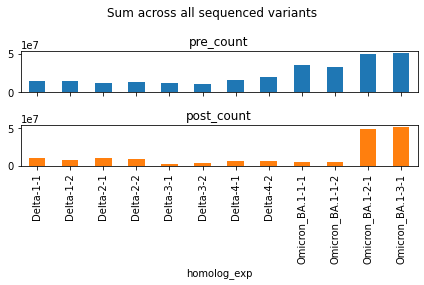

In [8]:
data = (func_score_df
    .groupby(["homolog_exp"])
    .sum()
    .reset_index()
#     .drop(["index"], axis=1)
).loc[:, ["pre_count", "post_count", "homolog_exp"]]
data.plot.bar(x="homolog_exp", subplots=True, legend=False)
plt.suptitle("Sum across all sequenced variants")
plt.tight_layout()
plt.show()

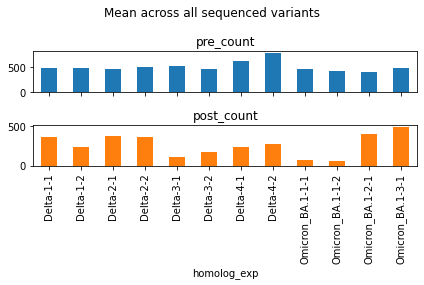

In [9]:
data = (func_score_df
    .groupby(["homolog_exp"])
    .mean()
    .reset_index()
#     .drop(["index"], axis=1)
).loc[:, ["pre_count", "post_count", "homolog_exp"]]
data.plot.bar(x="homolog_exp", subplots=True, legend=False)
plt.suptitle("Mean across all sequenced variants")
plt.tight_layout()
plt.show()

## Compute functional scores

In [10]:
# Rescale post-counts based on a bottleneck

func_score_col = 'log2e'
pseudocount = 0.1 # 10 #
dfs = []
for (h, hdf) in func_score_df.groupby(fs_scaling_group_column):
    n_post_counts = sum(hdf['post_count'])
    if 'Delta' in h:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    else:
        bottleneck = 1e5
        scaling_factor = bottleneck / n_post_counts # scaling_factor = 0.05
    hdf['orig_post_count'] = hdf['post_count']
    hdf['post_count'] *= scaling_factor
    hdf['post_count_wt'] *= scaling_factor
    print(h, n_post_counts, round(scaling_factor, 2), round(sum(hdf['post_count']),2))

    # Recompute enrichment ratios with new counts
    hdf['pre_count_ps'] = hdf['pre_count'] + pseudocount
    hdf['post_count_ps'] = hdf['post_count'] + pseudocount
    hdf['pre_count_wt_ps'] = hdf['pre_count_wt'] + pseudocount
    hdf['post_count_wt_ps'] = hdf['post_count_wt'] + pseudocount

    total_pre_count = sum(hdf['pre_count_ps'])
    total_post_count = sum(hdf['post_count_ps'])

    hdf['pre_freq'] = hdf['pre_count_ps'] / total_pre_count
    hdf['post_freq'] = hdf['post_count_ps'] / total_post_count
    hdf['pre_freq_wt'] = hdf['pre_count_wt_ps'] / total_pre_count
    hdf['post_freq_wt'] = hdf['post_count_wt_ps'] / total_post_count

    hdf['wt_e'] = hdf['post_freq_wt'] / hdf['pre_freq_wt']
    hdf['var_e'] = hdf['post_freq'] / hdf['pre_freq']
    hdf['e'] = hdf['var_e'] / hdf['wt_e']
    #hdf.dropna(subset=['e'], inplace=True)
    hdf['log2e'] = hdf['e'].apply(lambda x: math.log(x, 2))
    if (shift_func_scores) and (h == homolog_2):
        print(f'Shifting new functional scores for {h}')
        hdf[func_score_col] += shift_func_scores_nonref
    dfs.append(hdf)

func_score_df = pd.concat(dfs)

Delta-1-1 10412191 0.01 100000.0
Delta-1-2 6832932 0.01 100000.0
Delta-2-1 9730235 0.01 100000.0
Delta-2-2 9441867 0.01 100000.0
Delta-3-1 2610852 0.04 100000.0
Delta-3-2 4067102 0.02 100000.0
Delta-4-1 5696751 0.02 100000.0
Delta-4-2 6578291 0.02 100000.0
Omicron_BA.1-1-1 5324279 0.02 100000.0
Omicron_BA.1-1-2 4474327 0.02 100000.0
Omicron_BA.1-2-1 48050310 0.0 100000.0
Omicron_BA.1-3-1 51517292 0.0 100000.0


## Distribution of functional scores

In [27]:
# TODO Explain how this computed by bernadeta
# TODO how might we normalize this across experiments? with
# func_score_col = "func_score"

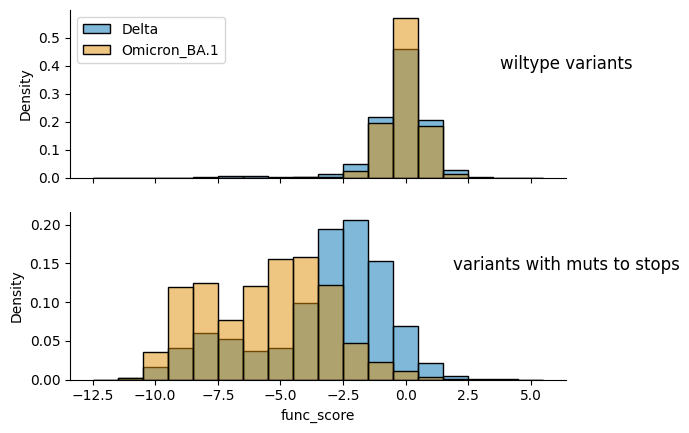

In [28]:
# # Initialize a list of dataframes to plot
# data_to_plot = []

# # Get data for wildtype variants
# data = func_score_df[func_score_df[substitution_col] == ''].copy()
# data_to_plot.append(('wiltype variants', data))

# # Get data for variants with stop codons
# data = func_score_df[
#     func_score_df[substitution_col].str.contains('\*')
# ].copy()
# data_to_plot.append(('variants with muts to stops', data))

# # Pre-determine bins
# min_val = -12 # math.floor(func_score_df[func_score_col].min())
# max_val = 5 # math.ceil(func_score_df[func_score_col].max())
# bin_size = 1
# bins = onp.arange(min_val - bin_size/2, max_val + bin_size, bin_size)

# # Plot data
# (fig, axs) = plt.subplots(nrows=2, sharex=True)
# pal = sns.color_palette('colorblind')
# for (i, (title, data)) in enumerate(data_to_plot):
#     for (c_i, (h, data_h)) in enumerate(data.groupby(homolog_name_col)):
#         sns.histplot(
#             x=func_score_col, data=data_h, bins=bins,
#             stat='density', color=pal.as_hex()[c_i], label=h,
#             alpha=0.5, ax=axs[i]
#         )
#     axs[i].set_title(title, x=1, y=0.6)
# axs[0].legend()
# sns.despine()
# plt.show()

For variants with stop codons, does the functional score correlate with the position of the stop codon in the gene? Or number of pre counts?

## Barcodes

In [39]:
# for exp, exp_df in func_score_df.groupby("homolog_exp"):
#     print(exp)
#     print(f"Unique variants: {len(exp_df.var_wrt_ref.unique())}")
#     print(f"Unique barcodes: {len(exp_df.barcode.unique())}") 

Delta-1-1
Unique variants: 23207
Unique barcodes: 26827
Delta-1-2
Unique variants: 23224
Unique barcodes: 26833
Delta-2-1
Unique variants: 18334
Unique barcodes: 24514
Delta-2-2
Unique variants: 18495
Unique barcodes: 24489
Delta-3-1
Unique variants: 18606
Unique barcodes: 21769
Delta-3-2
Unique variants: 18547
Unique barcodes: 21701
Delta-4-1
Unique variants: 18080
Unique barcodes: 23121
Delta-4-2
Unique variants: 18004
Unique barcodes: 23129
Omicron_BA.1-1-1
Unique variants: 42144
Unique barcodes: 68124
Omicron_BA.1-1-2
Unique variants: 42077
Unique barcodes: 68039
Omicron_BA.1-2-1
Unique variants: 63549
Unique barcodes: 107856
Omicron_BA.1-3-1
Unique variants: 54691
Unique barcodes: 93795


In [29]:
# num_variant_replicates = func_score_df[substitution_col].value_counts()
# print(num_variant_replicates)

In [11]:
func_score_df.to_csv("all_exp_func_scores_df.csv")